In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm

# Introduction

https://www.kaggle.com/birdy654/eeg-brainwave-dataset-feeling-emotions/notebooks?datasetId=93959&sortBy=voteCount

# Data

## Reading in the dataset

In [2]:
df = pd.read_csv('emotions.csv')
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


Source: https://www.researchgate.net/publication/329403546_Mental_Emotional_Sentiment_Classification_with_an_EEG-based_Brain-machine_Interface

https://www.researchgate.net/publication/335173767_A_Deep_Evolutionary_Approach_to_Bioinspired_Classifier_Optimisation_for_Brain-Machine_Interaction

We must first filter the dataset to optimize our model. As we can see, there are 2549 columns that get measured in this dataset. However, the model we chose only tests the "mean" columns. We note that the features we are using are the first 5 column and the label we are predicting is the last column. We will only select the columns accordingly so when we create the models, it will not loop through every column.

In [3]:
df = df.iloc[:, list(range(5)) + [-1]] # selects first 5 columns and last
df

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,label
0,4.620,30.3,-356.0,15.60,26.3,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,NEUTRAL
...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,NEGATIVE


## Data Preprocessing

We start by making sure the data is in an understandable format. First, we have to check if there are any missing values. This line below first checks if anything is null and returns true or false accordingly, then takes the sum of all true and false (true being 1, false being 0), and then checks if there exist any Trues.

In [4]:
df.isnull().sum().any()

False

This proves that there exists no missing values. This is a very good thing for us because this means that we do not have to compensate for any missing data. Next, the 'label' column is what we will be trying to predict. Let's get the unique values and see how the distribution is for all of the unique values.

In [5]:
labels = df['label']
unique_labels = np.unique(labels)
unique_labels

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

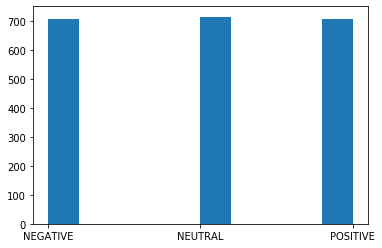

In [6]:
plt.hist(labels)
plt.show()

In [7]:
labels.value_counts()

NEUTRAL     716
POSITIVE    708
NEGATIVE    708
Name: label, dtype: int64

We can see that the labels we are trying to predict will be 'neutral', 'positive', or 'negative'. We also know that they are about equally distributed. For a logistic regression model, we will need to assign the strings into a corresponding value. In this case, negative will be 0, neutral will be 1, and positive will be 2.

In [8]:
new_labels = {key: val for val, key in enumerate(unique_labels)}
new_labels

{'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

With this new mapping, we can now create a new column to map these values.

In [9]:
df['new_label'] = df['label'].map(new_labels)
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,label,new_label
0,4.62,30.3,-356.0,15.6,26.3,NEGATIVE,0
1,28.80,33.1,32.0,25.8,22.8,NEUTRAL,1
2,8.90,29.4,-416.0,16.7,23.7,POSITIVE,2
3,14.90,31.6,-143.0,19.8,24.3,POSITIVE,2
4,28.30,31.3,45.2,27.3,24.5,NEUTRAL,1


The 'new_label' column corresponds to the 'label' column. Now, we must create a train/test split. This training subset will be used to train our model, and our testing subset will be used to test the accuracy of our model. For our project, we will be using a 80/20 train test split, which is a very common machine learning split because it provides a substantial amount of training data, as well as a good amount of data to test on.

In [10]:
X = df.drop(['label', 'new_label'], axis = 1)
y = df['new_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

In [11]:
X_train.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a
795,29.40,32.3,31.80,28.600,22.4
2083,14.30,30.5,-176.00,13.400,27.4
405,-3.52,25.1,4.27,-15.800,21.0
871,8.65,16.1,-303.00,0.494,27.1
1763,-2.07,18.4,-499.00,-0.984,26.8


In [12]:
y_train.head()

795     1
2083    0
405     2
871     0
1763    0
Name: new_label, dtype: int64

Now that we have a training/testing dataset, we can now proceed to train our model on the training the dataset.

# Creating the models

Because we are incorporating 5 different features, we will be cross-validating our models to make sure that we are not overfitting our model.

With 5 features, we will create 5 models:

$M1: \theta_0$ + $\theta_1$ * mean_0_a

$M2: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a

$M3: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a

$M4: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a + $\theta_4$ * mean_3_a

$M5: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a + $\theta_4$ * mean_3_a + $\theta_5$ * mean_4_a

Our process will be the same for each model: 
1. Create our feature vector by creating a column of ones
2. Convert the features into a list
3. Appending them to create a training vector
4. Train the model on it
5. Get the accuracy of each model on the training set

In [13]:
# one hot encodes the features, does step 1-3 from above
def one_hot_encoding(features, data):
    ones = np.ones(len(data))
    feat = [] # used to hold all the features after converting to a list
    
    # converts series into a list and stores it into a list
    for i in features:
        x_feat = data[i].tolist()
        feat.append(x_feat)
    
    X = np.vstack([ones, feat])
    X = X.T
    
    return X

### Model 1

In [14]:
# MODEL 1
X1 = one_hot_encoding(['# mean_0_a'], X_train)
X1

array([[ 1.  , 29.4 ],
       [ 1.  , 14.3 ],
       [ 1.  , -3.52],
       ...,
       [ 1.  , 27.8 ],
       [ 1.  , 19.9 ],
       [ 1.  , 29.3 ]])

In [15]:
m1 = svm.SVC(kernel = 'linear', C = 1.0)
m1.fit(X1, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
m1_pred = m1.predict(X1)
m1_pred

array([1, 0, 2, ..., 1, 0, 1])

In [18]:
# testing accuracy on m1
m1_acc = sum(m1_pred == y_train) / len(y_train)
m1_acc

0.6868035190615835

### Model 2

In [19]:
# MODEL 2
X2 = one_hot_encoding(['# mean_0_a', 'mean_1_a'], X_train)
X2

array([[ 1.  , 29.4 , 32.3 ],
       [ 1.  , 14.3 , 30.5 ],
       [ 1.  , -3.52, 25.1 ],
       ...,
       [ 1.  , 27.8 , 30.6 ],
       [ 1.  , 19.9 , 24.9 ],
       [ 1.  , 29.3 , 34.2 ]])

In [20]:
m2 = svm.SVC(kernel = 'linear', C = 1.0)
m2.fit(X2, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [21]:
m2_pred = m2.predict(X2)
m2

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
# testing accuracy on m2
m2_acc = sum(m2_pred == y_train) / len(y_train)
m2_acc

0.6832844574780058

### Model 3

In [23]:
# MODEL 3
X3 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a'], X_train)
X3

array([[   1.  ,   29.4 ,   32.3 ,   31.8 ],
       [   1.  ,   14.3 ,   30.5 , -176.  ],
       [   1.  ,   -3.52,   25.1 ,    4.27],
       ...,
       [   1.  ,   27.8 ,   30.6 ,   29.6 ],
       [   1.  ,   19.9 ,   24.9 , -202.  ],
       [   1.  ,   29.3 ,   34.2 ,   30.3 ]])

In [24]:
m3 = svm.SVC(kernel = 'linear', C = 1.0)
m3.fit(X3, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [25]:
m3_pred = m3.predict(X3)
m3_pred

array([1, 0, 2, ..., 1, 0, 1])

In [26]:
# testing accuracy on m3
m3_acc = sum(m3_pred == y_train) / len(y_train)
m3_acc

0.9079178885630499

### Model 4

In [27]:
# MODEL 4
X4 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a'], X_train)
X4

array([[   1.  ,   29.4 ,   32.3 ,   31.8 ,   28.6 ],
       [   1.  ,   14.3 ,   30.5 , -176.  ,   13.4 ],
       [   1.  ,   -3.52,   25.1 ,    4.27,  -15.8 ],
       ...,
       [   1.  ,   27.8 ,   30.6 ,   29.6 ,   26.4 ],
       [   1.  ,   19.9 ,   24.9 , -202.  ,   12.3 ],
       [   1.  ,   29.3 ,   34.2 ,   30.3 ,   27.  ]])

In [28]:
m4 = svm.SVC(kernel = 'linear', C = 1.0)
m4.fit(X4, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [29]:
m4_pred = m4.predict(X4)
m4

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [30]:
# testing accuracy on m4
m4_acc = sum(m4_pred == y_train) / len(y_train)
m4_acc

0.910850439882698

### Model 5

In [31]:
# MODEL 5
X5 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a'], X_train)
X5

array([[   1.  ,   29.4 ,   32.3 ,   31.8 ,   28.6 ,   22.4 ],
       [   1.  ,   14.3 ,   30.5 , -176.  ,   13.4 ,   27.4 ],
       [   1.  ,   -3.52,   25.1 ,    4.27,  -15.8 ,   21.  ],
       ...,
       [   1.  ,   27.8 ,   30.6 ,   29.6 ,   26.4 ,   23.6 ],
       [   1.  ,   19.9 ,   24.9 , -202.  ,   12.3 ,   26.8 ],
       [   1.  ,   29.3 ,   34.2 ,   30.3 ,   27.  ,   24.4 ]])

In [32]:
m5 = svm.SVC(kernel = 'linear', C = 1.0)
m5.fit(X5, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [33]:
m5_pred = m5.predict(X5)
m5_pred

array([1, 0, 2, ..., 1, 0, 1])

In [34]:
# testing accuracy on m5
m5_acc = sum(m5_pred == y_train) / len(y_train)
m5_acc

0.910850439882698

### Model Summary

It appears that model 4 performs the best on the training dataset. This could be because model 5 uses too many features so it overfits the model. Based on our training model accuracy, we will proceed this project using model #4, which was $M4: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a + $\theta_4$ * mean_3_a

## Testing Set

In [35]:
# converting testing set into a feature vector for our m4
x4 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a'], X_test)
x4

array([[  1.  ,  27.7 ,  30.2 ,  32.7 ,  28.9 ],
       [  1.  ,  19.  ,  31.6 , -90.8 ,  19.7 ],
       [  1.  ,  28.8 ,  30.8 ,  25.5 ,  27.3 ],
       ...,
       [  1.  ,   9.98,  29.3 ,  65.5 ,  17.3 ],
       [  1.  ,  33.3 ,  35.2 ,  24.1 ,  28.1 ],
       [  1.  ,  29.6 ,  30.7 ,  35.7 ,  28.2 ]])

In [36]:
pred = m4.predict(x4)
pred

array([1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1, 0, 0,
       2, 1, 0, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1,
       0, 0, 0, 2, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 1, 2, 1, 0, 2, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 1,
       2, 2, 0, 2, 1, 0, 2, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2,
       1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 2, 0, 1,
       0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 1, 1, 0,
       1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 1, 2, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 1, 1, 2,

In [37]:
# testing accuracy on testing set
testing_acc = sum(pred == y_test) / len(y_test)
testing_acc

0.9039812646370023

Our model predicted 87.8% correctly on the testing dataset.

1. Keep code here, perform same tests on a fixed dataset (top 80% / bottom 20% split)
2. Run the model that uses a random split multiple times
3. Use t-test to test significance difference between models (fixed dataset vs. random)
4. "does the time really matter in this dataset"
5. Pick best model, run multiple times in a loop and make a histogram to perform t-test